In [2]:
'''
- Authors: M. Guesmi/ S. Pani
- Mai 2024
- Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany
- Summary: FCCN to predict pressure drop
'''

'\n- Authors: M. Guesmi/ S. Pani\n- Mai 2024\n- Adress: Chair of process engineering TU Dresden, George-Bähr-Straße 3b, 01069 Dresden, Germany\n- Summary: FCCN to predict pressure drop\n'

In [3]:
# TODO 
# research for evaluation metrics 
# find out the difference in loss function between SI-Dataset and non-SI dataset. Normalize
# Normalize data set. Reduce the values to [-1, 1] + Documentation 
# TODO 04.06.2024
# add some literature: which evaluation metrics?? 
# MAE, RMSE, coeff. of determination R^2 (cite...)
# what else?
# number of epochs: performance and computing time

In [4]:
#!python -m pip  install torch
#!python -m pip  install scikit-learn

In [5]:
import numpy as np
import torch #tensorflow
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import copy
import time

In [6]:
# Load the CSV file into a DataFrame
dataset = pd.read_csv("mmc1_SI copy.csv", header=None) # SI units

# Remove the first row from the dataset
dataset = dataset[dataset.index >= 1]

# Split features and labels
X_all = dataset.iloc[:, :5]
y_all = dataset.iloc[:, 5]

# Convert the labels to numeric
y_all = pd.to_numeric(y_all, errors='coerce')

In [7]:
# Define the threshold for splitting the data
threshold = 5000

# Split the data into two sets based on the pressure drop value
indices_under_5000 = np.abs(y_all.values) < threshold
indices_over_5000 = np.abs(y_all.values) >= threshold

X_under_5000 = X_all[indices_under_5000]
y_under_5000 = y_all[indices_under_5000]
X_over_5000 = X_all[indices_over_5000]
y_over_5000 = y_all[indices_over_5000]

# Split each set into training and testing sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under_5000, y_under_5000, test_size=0.2, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over_5000, y_over_5000, test_size=0.2, random_state=42)

# Normalize the training and test sets
scaler_X_under = StandardScaler()
X_train_under = scaler_X_under.fit_transform(X_train_under)
X_test_under = scaler_X_under.transform(X_test_under)

scaler_Y_under = StandardScaler()
y_train_under = scaler_Y_under.fit_transform(y_train_under.values.reshape(-1, 1))
y_test_under = scaler_Y_under.transform(y_test_under.values.reshape(-1, 1))

scaler_X_over = StandardScaler()
X_train_over = scaler_X_over.fit_transform(X_train_over)
X_test_over = scaler_X_over.transform(X_test_over)

scaler_Y_over = StandardScaler()
y_train_over = scaler_Y_over.fit_transform(y_train_over.values.reshape(-1, 1))
y_test_over = scaler_Y_over.transform(y_test_over.values.reshape(-1, 1))

# Convert to tensors
x_train_tensor_under = torch.tensor(X_train_under, dtype=torch.float32)
y_train_tensor_under = torch.tensor(y_train_under, dtype=torch.float32).reshape(-1, 1)
x_test_tensor_under = torch.tensor(X_test_under, dtype=torch.float32)
y_test_tensor_under = torch.tensor(y_test_under, dtype=torch.float32).reshape(-1, 1)

x_train_tensor_over = torch.tensor(X_train_over, dtype=torch.float32)
y_train_tensor_over = torch.tensor(y_train_over, dtype=torch.float32).reshape(-1, 1)
x_test_tensor_over = torch.tensor(X_test_over, dtype=torch.float32)
y_test_tensor_over = torch.tensor(y_test_over, dtype=torch.float32).reshape(-1, 1)

# Create DataLoader for training data
batch_size = 20
train_data_under = TensorDataset(x_train_tensor_under, y_train_tensor_under)
train_loader_under = DataLoader(train_data_under, batch_size=batch_size, shuffle=True)

train_data_over = TensorDataset(x_train_tensor_over, y_train_tensor_over)
train_loader_over = DataLoader(train_data_over, batch_size=batch_size, shuffle=True)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.hidden1 = nn.Linear(5, 250)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)  # Add dropout after the first hidden layer

        self.hidden2 = nn.Linear(250, 400)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)  # Add dropout after the second hidden layer

        self.hidden3 = nn.Linear(400, 180)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)  # Add dropout after the third hidden layer

        self.hidden4 = nn.Linear(180, 80)
        self.act4 = nn.ReLU()

        self.output = nn.Linear(80, 1)

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout1(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout2(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout3(x)
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x


In [9]:
"""# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.hidden1 = nn.Linear(5, 250)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(250, 400)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(400, 180)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(180, 80)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(80, 1)
        
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x"""

'# Define the FCNN model\nclass FCNN(nn.Module):\n    def __init__(self):\n        super(FCNN, self).__init__()\n        self.hidden1 = nn.Linear(5, 250)\n        self.act1 = nn.ReLU()\n        self.hidden2 = nn.Linear(250, 400)\n        self.act2 = nn.ReLU()\n        self.hidden3 = nn.Linear(400, 180)\n        self.act3 = nn.ReLU()\n        self.hidden4 = nn.Linear(180, 80)\n        self.act4 = nn.ReLU()\n        self.output = nn.Linear(80, 1)\n        \n    def forward(self, x):\n        x = self.act1(self.hidden1(x))\n        x = self.act2(self.hidden2(x))\n        x = self.act3(self.hidden3(x))\n        x = self.act4(self.hidden4(x))\n        x = self.output(x)\n        return x'

In [10]:
# Initialize the network, optimizer and criterion
"""model =     FCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Lower the learning rate 0.0001
loss_fn = nn.MSELoss() """

'model =     FCNN()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Lower the learning rate 0.0001\nloss_fn = nn.MSELoss() '

In [11]:
# Function to train the FCNN model
def train_model(n_epochs, model, optimizer, loss_fn, train_loader, x_test_tensor, y_test_tensor):
    best_mse = float('inf')
    best_model_state = None

    train_losses = []
    history = []

    start_time = time.time()

    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0.0

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            y_pred = model(x_test_tensor)
            mse = loss_fn(y_pred, y_test_tensor)
            mse = float(mse)
            history.append(mse)
            if mse < best_mse:
                best_mse = mse
                best_model_state = copy.deepcopy(model.state_dict())

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, best_mse, best_model_state, history, training_time

Training and evaluating model for pressure drop under 5000 Pa:
Mean Absolute Error (MAE): 416.8640
Mean Squared Error (MSE): 332642.6250
Root Mean Squared Error (RMSE): 576.7518
Coefficient of Determination (R^2): 0.8834
Mean Absolute Percentage Error (MAPE): 37.5200%


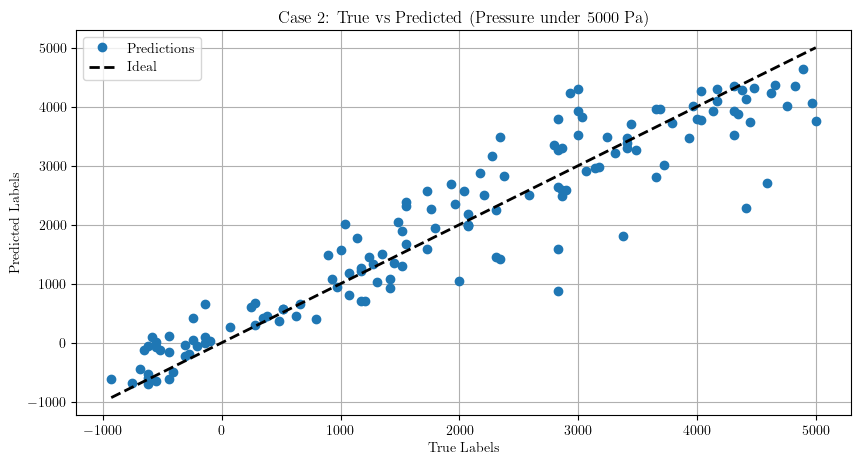

Training and evaluating model for pressure drop over 5000 Pa:
Mean Absolute Error (MAE): 1011.7674
Mean Squared Error (MSE): 1736208.6250
Root Mean Squared Error (RMSE): 1317.6527
Coefficient of Determination (R^2): 0.9711
Mean Absolute Percentage Error (MAPE): 7.8747%


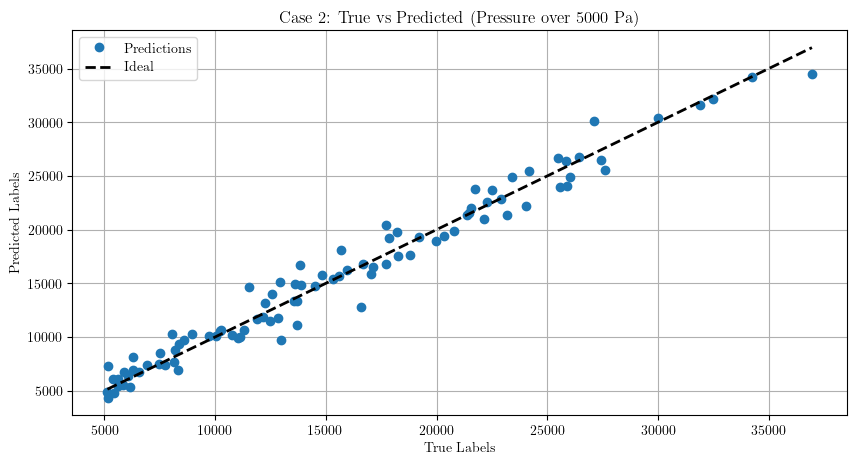

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# Enable PGF backend for LaTeX-style formatting
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Use pdflatex for processing
    "font.family": "serif",       # Use serif fonts
    "text.usetex": True,          # Enable LaTeX
    "pgf.rcfonts": False          # Ignore rc settings in pgf
})

def train_and_evaluate(n_epochs, train_loader, x_test_tensor, y_test_tensor, scaler_Y, filename, title):
    # Define the model (Assume FCNN is your neural network class)
    model = FCNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()

    # Train the model
    train_losses, best_mse, best_model_state, history, training_time = train_model(
        n_epochs, model, optimizer, loss_fn, train_loader, x_test_tensor, y_test_tensor
    )

    # Load the best model state for evaluation
    model.load_state_dict(best_model_state)
    model.eval()

    # Get predictions on the test data
    with torch.no_grad():
        y_test_pred = model(x_test_tensor)

    # Convert tensors to numpy arrays
    y_test_np = y_test_tensor.cpu().numpy()
    y_test_pred_np = y_test_pred.cpu().numpy()

    # Unnormalize the true and predicted values
    y_test_pred_unscaled = scaler_Y.inverse_transform(y_test_pred_np)
    y_test_unscaled = scaler_Y.inverse_transform(y_test_np)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
    mape = np.mean(np.abs((y_test_unscaled - y_test_pred_unscaled) / y_test_unscaled)) * 100

    # Print evaluation metrics
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Coefficient of Determination (R^2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_unscaled, y_test_pred_unscaled, 'o', label='Predictions')
    plt.plot(
        [y_test_unscaled.min(), y_test_unscaled.max()],
        [y_test_unscaled.min(), y_test_unscaled.max()],
        'k--',
        lw=2,
        label='Ideal'
    )
    plt.grid(True)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(title)
    plt.legend()
    
    # Save the plot as a PNG file with LaTeX formatting
    plt.savefig(filename, format="png", dpi=300)  # Set high DPI for quality
    plt.show()

    return model, train_losses, best_mse, history, training_time, y_test_unscaled, y_test_pred_unscaled, y_test_np, y_test_pred_np


# Train and evaluate the model for pressure drop below the threshold
n1 = 400
print("Training and evaluating model for pressure drop under 5000 Pa:")
model_under, train_losses_under, best_mse_under, history_under, training_time_under, y_test_unscaled_under, y_test_pred_unscaled_under, y_test_np_under, y_test_pred_np_under = train_and_evaluate(
    n1, train_loader_under, x_test_tensor_under, y_test_tensor_under, scaler_Y_under,
    filename="Fig2aTrue_vs_predicted_under_5000.png",
    title="Case 2: True vs Predicted (Pressure under 5000 Pa)"
)

# Train and evaluate the model for pressure drop above the threshold
n2 = 300
print("Training and evaluating model for pressure drop over 5000 Pa:")
model_over, train_losses_over, best_mse_over, history_over, training_time_over, y_test_unscaled_over, y_test_pred_unscaled_over, y_test_np_over, y_test_pred_np_over = train_and_evaluate(
    n2, train_loader_over, x_test_tensor_over, y_test_tensor_over, scaler_Y_over,
    filename="Fig 2bTrue_vs_predicted_over_5000.png",
    title="Case 2: True vs Predicted (Pressure over 5000 Pa)"
)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Concatenate predictions and true values
y_test_pred_unscaled_total = np.concatenate((y_test_pred_unscaled_under, y_test_pred_unscaled_over), axis=0)
y_test_unscaled_total = np.concatenate((y_test_unscaled_under, y_test_unscaled_over), axis=0)

# Concatenate predictions and true values (SCales)
y_test_pred_np_total = np.concatenate((y_test_pred_np_under, y_test_pred_np_over), axis=0)
y_test_np_total = np.concatenate((y_test_np_under, y_test_np_over), axis=0)

# Compute evaluation metrics for the combined dataset
total_mse = mean_squared_error(y_test_unscaled_total,y_test_pred_unscaled_total)
total_rmse = np.sqrt(total_mse)
total_mae = mean_absolute_error(y_test_unscaled_total,y_test_pred_unscaled_total)
r2 = r2_score(y_test_unscaled_total,y_test_pred_unscaled_total)
total_mape = np.mean(np.abs((y_test_unscaled_total - y_test_pred_unscaled_total) / y_test_unscaled_total)) * 100

# Print the results
print(f'Total Mean Absolute Error (MAE): {total_mae:.4f}')
print(f'Total Mean Squared Error (MSE): {total_mse:.4f}')
print(f'Total Root Mean Squared Error (RMSE): {total_rmse:.4f}')
print(f'Coefficient of Determination (R^2): {r2:.4f}')
print(f'Total Mean Absolute Percentage Error (MAPE): {total_mape:.4f}%')

Total Mean Absolute Error (MAE): 654.8254
Total Mean Squared Error (MSE): 894069.0000
Total Root Mean Squared Error (RMSE): 945.5522
Coefficient of Determination (R^2): 0.9873
Total Mean Absolute Percentage Error (MAPE): 25.6619%


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Enable PGF backend for LaTeX-style formatting
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Use pdflatex for processing
    "font.family": "serif",       # Use serif fonts
    "text.usetex": True,          # Enable LaTeX
    "pgf.rcfonts": False          # Ignore rc settings in pgf
})

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_unscaled_total, y_test_pred_unscaled_total, 'o', label='Predictions')
plt.plot([y_test_unscaled_total.min(), y_test_unscaled_total.max()], 
         [y_test_unscaled_total.min(), y_test_unscaled_total.max()], 'k--', lw=2, label='y=x line')

# Plot the ±10% lines with the same style
a = 10  # Percentage
b = a / 100
plt.plot([y_test_unscaled_total.min(), y_test_unscaled_total.max()],
         [(1-b) * y_test_unscaled_total.min(), (1-b) * y_test_unscaled_total.max()], 
         'r--', lw=2, label='$\pm10\%$ bounds')  # Green dashed line
plt.plot([y_test_unscaled_total.min(), y_test_unscaled_total.max()],
         [(1+b) * y_test_unscaled_total.min(), (1+b) * y_test_unscaled_total.max()], 
         'r--', lw=2)  
# Set plot details
plt.grid(True)
plt.xlabel('True Labels (Pressure drop in Pa)')
plt.ylabel('Predicted Labels (Pressure drop in Pa)')
plt.title('True vs Predicted Labels on Test Data')
plt.legend()

# Save the plot as a PNG file with high resolution
png_path = "Fig_2cTrue_vs_Predicted_Labels.png"
plt.savefig(png_path, format="png", dpi=300)  # High DPI for quality
plt.close()  # Close the plot to avoid overwriting

# Print confirmation
print(f"Plot saved as: {png_path}")


Plot saved as: Fig_2cTrue_vs_Predicted_Labels.png
